# Питон и машинное обучение

# Модуль 6, часть 1. Байесовский классификатор. Деревья решений.

В рамках данного модуля мы рассмотрим методы машинного обучения, основанные на предварительном частотном/вероятностном анализе набора данных:
- Байесовский классификатор
    - Теорема Байеса
    - Разновидности "Наивного Байесовского Классификатора" и области их применений
- Деревья решений: 
    - Как они формируются
    - Визуализация, интерпретация
    - Использование "деревьев" в задачах регрессии.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('always', category=UserWarning)

## Наивный Байесовский классификатор

### Теорема Байеса

__Априорная вероятность__ - это наша изначальная оценка вероятности события, до того как мы учли новую информацию. Она основывается на предварительных знаниях или интуиции, до наблюдения за новыми данными.

__Апостериорная вероятность__ - это обновленная вероятность события, полученная после учета новой информации. Это то, чему нас учит теорема Байеса: как переоценить наши предыдущие вероятности в свете новых данных.

#### "Адам и восход солнца":

Событие $A$ - "солнце встает каждый день".

Событие $B$ - "солнце встает сегодня".

$\Large P(\textrm{A } | \textrm{ B}) = \frac{P(\textrm{B }| \textrm{ A}) * P(\textrm{A})}{P(\textrm{B})} 
= 
\frac{P(\textrm{B }
| \textrm{ A})
*
P(\textrm{A})}{P(\textrm{B } | \textrm{ A})P(\textrm{A}) + 
P(\textrm{B } |
\textrm{
~A})P(\textrm{~A})}
$

В нашем случае:

- $P(A∣B)$ — апостериорная вероятность события $A$ при условии, что произошло событие $B$: "солнце взошло сегодня, значит оно взойдет завтра"
- $P(B∣A)$ — вероятность наблюдения события $B$ при условии, что событие $A$ истинно: "солнце взошло сегодня"
- $P(A)$ — априорная вероятность события $A$: интуитивная оценка того, что "солнце восходит каждый день", она крепнет с каждым днем: мы можем брать нашу вчерашнюю апостериорную вероятность и использовать ее сегодня
- $P(B)$ — полная вероятность события $B$, которая может быть рассчитана как сумма вероятностей $B$, взвешенных по всем возможным сценариям $A$: "солнце взошло с учетом наших преположений, и без оных".

...и код к примеру "Адам и восход солнца":

In [ ]:
days = np.arange(1, 10+1)

def bayes(a, b_a, b_not_a):
    num = b_a * a
    denom = b_a * a + b_not_a * (1-a)
    return round(num/denom, 4)
    
p_start = 0.01 # должна же быть хоть какая-то надежда?

print("Вероятность события A при условии B: {}" \
      .format( bayes(p_start, 
                    b_a=1, # факт "солнце взошло"p=1
                    b_not_a=1/7 # "солнце взошло вопреки нашим надеждам" p=1/<кол-во дней наблюдения>
                    ) ))

# посчитаем для двух случаев: когда мы более-менее уверены и когда не очень:
posteriors = [ p_start ] # 1. начнем с 0.01
posteriors_less_conf = [ p_start/1e2 ] # 2. начнем с 0.0001

for i, day in enumerate(days):
    if i==0: continue
    posteriors += [ bayes(posteriors[i-1], 
                    b_a=1, 
                    b_not_a=1/len(days)) ]
    posteriors_less_conf += [ bayes(posteriors_less_conf[i-1], 
                    b_a=1, 
                    b_not_a=1/len(days)) ]


print(posteriors)
print(posteriors_less_conf)

In [ ]:
fig, ax = plt.subplots(1,1)

ax.set_title('Вероятность того, что солнце будет всходить и далее')
ax.set_ylabel("Вероятность")
ax.set_xlabel("Дни наблюдений")
ax.plot(days, posteriors, linestyle=':', marker='o', label=f"P(A): {p_start}")
ax.plot(days, posteriors_less_conf, linestyle=':', marker='o', label=f"P(A): {p_start/1e2}")

ax.legend(loc='best')

plt.show()

### Байесовский классификатор

Байесовский классификатор — это статистический алгоритм, использующий принципы теоремы Байеса для классификации объектов. Он относит объекты к классам на основе вероятностей, вычисляя, какова вероятность того, что данный объект принадлежит к каждому из возможных классов, исходя из атрибутов (или "фич") этого объекта.

Вот как работает байесовский классификатор в общих чертах:
- **Подготовка данных**: Для начала, алгоритму необходимо "обучиться" на наборе данных, где для каждого объекта известен класс. Во время этого обучения алгоритм вычисляет вероятности связи между атрибутами объектов и их классами. Эти вероятности называются условными вероятностями.
- **Априорные вероятности**: Также алгоритм вычисляет априорные вероятности каждого класса — то есть, насколько часто каждый класс встречается в обучающем наборе данных. Это дает базовую оценку вероятности того, что случайно выбранный объект принадлежит к каждому из классов.
- **Классификация новых объектов**: Когда появляется новый объект для классификации, алгоритм использует вычисленные условные вероятности, чтобы оценить вероятность того, что этот объект принадлежит к каждому из возможных классов, учитывая атрибуты нового объекта. Это делается путем применения формулы теоремы Байеса.
- **Выбор класса**: В конце концов, объект классифицируется как принадлежащий к тому классу, вероятность которого оказалась выше всех. Это называется апостериорной вероятностью.

Для простоты представим, что у нас есть два класса: $C_1$ и $C_2$, и один атрибут $X$. Тогда апостериорные вероятности классификации объекта с атрибутом $X$ в каждом из классов будут вычисляться как:

$\Large P(C_1 ∣ X) = \frac{P(X ∣ C_1) * P(C_1)}{P(X)}$

$\Large P(C_2 ∣ X) = \frac{P(X ∣ C_2) * P(C_2)}{P(X)}$

где $P(C_1 ∣ X)$ и $P(C_2 ∣ X)$ — это апостериорные вероятности классов, $P(X ∣ C_1)$ и $P(X ∣ C_2)$ - условные вероятности атрибута $X$ для каждого класса, $P(C_1)$ и $P(C_2)$ - априорные вероятности классов, и $P(X)$ — полная вероятность атрибута $X$.

Байесовский классификатор особенно хорош, когда количество атрибутов (фич) велико, как, например, в задачах классификации текстов. Один из наиболее известных примеров байесовского классификатора — это __Наивный Байесовский Классификатор__, который предполагает, что все атрибуты независимы друг от друга внутри класса, что упрощает вычисления и, несмотря на свою "наивность", часто дает вполне приемлемые результаты.

Пример на датасете "[Spambase](https://archive.ics.uci.edu/dataset/94/spambase)":

In [ ]:
spambase = pd.read_csv('data/spambase.csv')
spambase

In [ ]:
spambase.describe()

In [ ]:
X, y = spambase.iloc[:,:-1], spambase.iloc[:,-1]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_spambase_minmax = pd.DataFrame(MinMaxScaler().fit_transform(X), 
                           columns = X.columns )

In [ ]:
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   stratify = y)

print(X_train.shape, X_test.shape)
print(y.to_numpy()[:20])

model = MultinomialNB(alpha=0.1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(f"Accuracy score: {roc_auc_score(y_test, y_pred)}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_proba[:, -1])}")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_spambase_minmax, y, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   stratify = y)
model = MultinomialNB(alpha=0.1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print(f"Accuracy score: {roc_auc_score(y_test, y_pred)}")
print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred_proba[:, -1])}")

#### Выбор типа наивного байесовского классификатора

- Если ваши данные являются бинарными ("0/1" в one-hot-encoding), то лучше всего подойдет __BernoulliNB__.
- Для счетных данных, например, частот слов в тексте, предпочтительнее __MultinomialNB__.
- Когда признаки являются непрерывными и можно предположить, что они распределены нормально, выбирайте __GaussianNB__.
- Когда данные категориальные, стоит выбрать __CategorialNB__.
- Для ситуаций, когда вам нужно работать с несбалансированными датасетами, и вы ищете классификатор, который лучше справится с этой проблемой, особенно в случае классификации текстов, можно выбрать __ComplementNB__.

In [ ]:
from sklearn.naive_bayes import ComplementNB

model = ComplementNB(alpha=0.01)

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)

print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred[:, -1])}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)

print(f"ROC-AUC score: {roc_auc_score(y_test, y_pred[:, -1])}")

#### ⁉️ Задание

Для датасета "Ирисы" выберите подходящий наивный байесовский классификатор, обучите его и получите максимально возможное значение точности (accuracy).

In [ ]:
from sklearn import datasets

iris_raw = datasets.load_iris()
iris = pd.DataFrame(iris_raw.data, columns=iris_raw.feature_names)
iris['y'] = iris_raw.target
iris

In [ ]:
#ваш код здесь



## Деревья решений

Дерево решений — это инструмент поддержки принятия решений, который использует древовидную графическую модель возможных решений. 

В процессе машинного обучения алгоритм "дерево решений" формирует граф, путь по которому предсказывает значение целевой переменной на основе нескольких входных переменных. Процесс начинается с корневого узла, который делится на возможные варианты решений, каждый из которых ведёт к дополнительным узлам с новыми вариантами. Этот процесс продолжается до тех пор, пока не будут достигнуты конечные узлы, называемые листьями, которые представляют прогнозируемые значения или решения.

Решение о каждом разветвлении принимается на основании вычисленных статистических метрик вначале по исходному множеству, а потом по отсеченным подмножествам.

Основные преимущества деревьев решений:

- **Простота понимания и интерпретации.** Деревья можно легко визуализировать и понять даже без глубоких знаний в области статистики.
- **Требует мало подготовки данных.** В отличие от многих других алгоритмов, не требуется нормализация данных.
- **Способность работать с числовыми и категориальными данными.** Деревья решений могут обрабатывать данные различных типов.
- **Используется для решения задач как классификации, так и регрессии.**

Недостатки деревьев решений включают склонность к переобучению, особенно с комплексными деревьями, и сложность в обобщении модели на новые данные, что может привести к ошибкам в прогнозах. Для борьбы с этими недостатками используются различные методы, такие как обрезка дерева, а также ансамблевые методы машинного обучения, такие как случайные леса, которые строят множество деревьев решений и объединяют их предсказания.

__Пример__:

In [ ]:
tennis = pd.read_csv('data/PlayTennis.csv')
tennis

Дерево решений для задачи "пойду ли я играть в теннис" (сделано человеком):
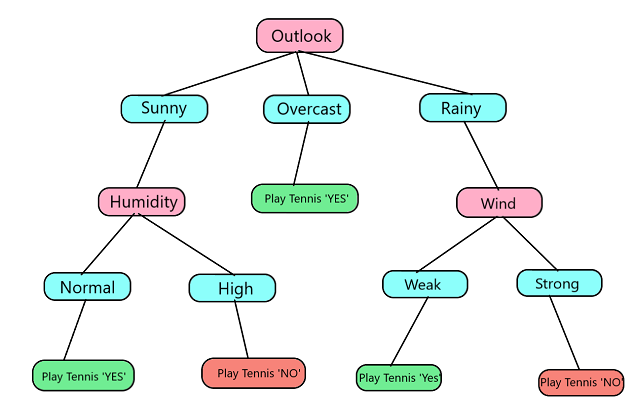

Попробуем обучить и визуализировать дерево решений:

In [ ]:
# препроцессинг
df_outlook = pd.get_dummies(tennis.Outlook, dtype=np.int64, prefix="Outlook")
df_temperature = pd.get_dummies(tennis.Temperature, dtype=np.int64, prefix="Temperature")
tennis['Humidity'] = tennis.Humidity.apply(lambda x: 1 if x=='High' else 0)
tennis['Wind'] = tennis.Wind.apply(lambda x: 1 if x=='Strong' else 0)
tennis['Play Tennis'] = tennis['Play Tennis'].apply(lambda x: 1 if x=='Yes' else 0)

tennis = pd.concat([df_outlook, df_temperature, tennis], axis=1).drop(['Outlook', 'Temperature'], axis=1)
tennis

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

tennis_tree = DecisionTreeClassifier(criterion='gini')

X, y = tennis.iloc[:, :-1], tennis.iloc[:,-1]

tennis_tree.fit(X, y)

fig, ax = plt.subplots( figsize = (10,10) )
tree.plot_tree(tennis_tree,
               feature_names = X.columns, 
               class_names=['No','Yes'],
               filled = True)
plt.plot()

В деревьях решений разбиение выборки на подгруппы происходит на основе принципа, который стремится максимизировать однородность или чистоту узлов после разделения. Цель состоит в том, чтобы создать подгруппы, в которых объекты будут как можно более схожи по целевому признаку. Есть несколько ключевых метрик и принципов, используемых для оценки качества разбиения:

1. **Индекс Джини** (```gini```, используется по умолчанию) \
Индекс Джини — ещё одна мера, используемая для определения чистоты разделения. Она измеряет вероятность того, что случайно выбранный элемент из набора будет неправильно классифицирован, если он случайно классифицируется в соответствии с распределением классов в подгруппе. Меньшее значение индекса Джини указывает на лучшее разбиение.

    $\Large H(Q_m) = \sum_k p_{mk} (1 - p_{mk})$
    
<br>

2. **Энтропия** (```entropy```) \
Энтропия — это мера неопределенности или беспорядка в наборе данных. В контексте деревьев решений она используется для определения чистоты узла. Энтропия узла уменьшается, если он содержит больше объектов одного класса, и увеличивается, если объекты равномерно распределены по разным классам. Разбиение выбирается таким образом, чтобы энтропия после разбиения уменьшилась по сравнению с исходной энтропией.

    $\Large H(Q_m) = - \sum_k p_{mk} \log(p_{mk})$
    
    

Процесс выбора атрибута для разбиения:
- Для каждого атрибута рассчитывают метрику качества разбиения (например, прирост информации или индекс Джини).
- Выбирают атрибут, разбиение по которому дает лучшее значение выбранной метрики.
- Процесс разбиения повторяется рекурсивно для каждой полученной подгруппы, пока не будут достигнуты условия остановки (например, все объекты в узле принадлежат к одному классу, достигнута максимальная глубина дерева или количество объектов в узле меньше заданного порога).

Также для понимания принципов работы "Деревьев решений" полезно увидеть, как классификатор разбивает разделяет пространство признаков разных классов.

Два класса будут сгенерированы в двухмерном пространстве из двух нормальных распределений с разными средними.

In [ ]:
np.random.seed(20240406)
n_samples = 100

# первый класс
train_data = np.random.normal(size=(n_samples, 2))
train_labels = np.zeros(n_samples)

# второй класс
train_data = np.r_[train_data, np.random.normal(size=(n_samples, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(n_samples)]

In [ ]:
from plot_decision_regions import plot_decision_regions

fig, ax = plt.subplots( figsize=(6,6) )

plot_decision_regions(train_data, train_labels)

In [ ]:
dtree = DecisionTreeClassifier(min_samples_leaf=5)

dtree.fit(train_data, train_labels)

fig, ax = plt.subplots( figsize=(6,6) )

plot_decision_regions(train_data, train_labels, dtree)

In [ ]:
fig, ax = plt.subplots( figsize = (10,10) )
tree.plot_tree(dtree,
               feature_names = ['x', 'y'], 
               class_names=['0','1'],
               filled = True)
plt.plot()

## Дерево решений в задаче регрессии

Здесь в качестве критерия чаще всего используют среднеквадратичную ошибку:

$\Large \begin{align}\begin{aligned}\bar{y}_m = \frac{1}{n_m} \sum_{y \in Q_m} y\\H(Q_m) = \frac{1}{n_m} \sum_{y \in Q_m} (y - \bar{y}_m)^2\end{aligned}\end{align}$

#### Пример

Сгенерируем данные, распределенные вокруг функции  $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$  c некоторым шумом.

In [ ]:
n_train = 150        
n_test = 1000       
noise = 0.1


def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
     
rtree = DecisionTreeRegressor()

rtree.fit(X_train, y_train)
d_predict = rtree.predict(X_test)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - d_predict) ** 2))
plt.show()

Визуализируем дерево:

In [ ]:
fig, axes = plt.subplots( figsize = (10,10) )
tree.plot_tree(rtree,
               feature_names = ['value'], 
               filled = True)

plt.show()

Конечно, можно представить дерево в виде кода, например, на Python:

In [ ]:
from tree_to_code import tree_to_code

tree_to_code(tennis_tree, tennis.columns[:-1])

#### ⁉️ Задание

1. Для датасета "Spambase" получите максимальное значение метрики ROC-AUC, варьируя параметры классификатора "Дерево решений".

In [ ]:
spambase = pd.read_csv('data/spambase.csv')
# ваш код здесь



2. Для датасета "penguins" выполнтие необходимый препроцессинг, обучите дерево решений, получите значение метрик ```accuracy```, ```f1``` и ```roc_auc```. Визуализируйте дерево решений, интерпретируйте результат. 

In [ ]:
penguins = sns.load_dataset("penguins")
penguins

In [ ]:
# ваш код здесь



## Используемые материалы и полезные ссылки

- [A Bayesian quest to find God (статья на towardsdatascience.com)](https://towardsdatascience.com/a-bayesian-quest-to-find-god-b30934972473)
- [Naive Bayes Classification (статья на Medium.com)](https://towardsdatascience.com/naive-bayes-classification-41d1fe802a1e)
- [Spam detection using Scikit learn (пример поиска спама, на kaggle.com)](https://www.kaggle.com/code/yakinrubaiat/spam-detection-using-scikit-learn)
- [Наивный Байес, или о том, как математика позволяет фильтровать спам (статья на Хабре)](https://habr.com/ru/articles/415963/)
- [Наивный байесовский алгоритм (статья на Medium.com)](https://medium.com/nuances-of-programming/наивный-байесовский-алгоритм-всё-что-нужно-о-нём-знать-85f6e04c3b74)

<hr>

- [Understanding the decision tree structure (scikit-learn.org)](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)
- [Visualize a Decision Tree in 4 Ways with Scikit-Learn and Python](https://mljar.com/blog/visualize-decision-tree/)
- [Converting a DecisionTree into python code](http://www.clungu.com/Converting_a_DecisionTree_into_python_code/)
